# Fix pathing

In [1]:
import sys


sys.path.append("../..")


In [2]:
import constants

import os


constants.PROJECT_DIRECTORY_PATH = os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(constants.PROJECT_DIRECTORY_PATH))))


# Imports

In [3]:
import plotter
import datahandler

import matplotlib.pyplot
import numpy as np
import pandas as pd
import seaborn as sns
import IPython.display


# Constants

In [4]:
FOLDER_NAME = "2024_04_16_23_06_25_NSGA2"

FOLDER_PATH = os.path.join(os.path.dirname(constants.PROJECT_DIRECTORY_PATH), "Simulator", "data", FOLDER_NAME)


In [5]:
data_preprocessor = datahandler.DataPreprocessorOUS_V2()
data_preprocessor.execute()

data_loader = datahandler.DataLoader(datahandler.DataPreprocessorOUS_V2)
data_loader.execute(False, False, True)


Loading dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 2/2 [00:02<00:00,  1.42s/it]


# Methods

In [6]:
def load_csv():
    df = pd.read_csv(os.path.join(FOLDER_PATH, "events.csv"))

    response_time_cols = [
        'duration_incident_creation',
        'duration_resource_appointment',
        'duration_resource_preparing_departure',
        'duration_dispatching_to_scene'
    ]
    df['total_response_time'] = df[response_time_cols].sum(axis=1)

    return df


In [7]:
def plot_response_time_density(df):
    matplotlib.pyplot.figure(figsize=(12, 8))

    for triage_category in ["A", "H", "V1"]:
        subset = df[df['triage_impression_during_call'] == triage_category]
        sns.kdeplot(subset['total_response_time'] / 60, bw_adjust=0.5, label=f'Triage {triage_category}', fill=True)

    matplotlib.pyplot.title('Response Time Density by Triage Category')
    matplotlib.pyplot.xlabel('Response Time (minutes)')
    matplotlib.pyplot.ylabel('Density')
    matplotlib.pyplot.legend()
    matplotlib.pyplot.show()


In [8]:
def print_mean_median(df: pd.DataFrame):
    stats = df.groupby(['triage_impression_during_call', 'urban'])['total_response_time'].agg(['mean', 'median']).reset_index()
    stats['mean'] = (stats['mean'] / 60).round(2)
    stats['median'] = (stats['median'] / 60).round(2)
    stats.rename(columns={
        'triage_impression_during_call': 'Triage',
        'mean': 'Mean (min)',
        'median': 'Median (min)',
        'urban': 'Urban'
    }, inplace=True)
    stats['Urban'] = stats['Urban'].map({True: 'Yes', False: 'No'})
    stats.sort_values(by=["Urban", "Triage"], ascending=[False, True], inplace=True)
    IPython.display.display(stats.style.hide(axis='index'))


In [9]:
def boxplot_time_at_steps_modified(
    dataframe: pd.DataFrame,
    triage_impression: str = None
):
    title = "Time Taken At Each Step of the Incident"

    if triage_impression is not None:
        # Filter the dataframe without overwriting the original one
        temp_df = dataframe[dataframe["triage_impression_during_call"] == triage_impression].copy()
        title += f" ({triage_impression})"
    else:
        # Use the original dataframe if no triage_impression filter is applied
        temp_df = dataframe.copy()

    steps = {
        "Creating Incident": "duration_incident_creation",
        "Appointing Resource": "duration_resource_appointment",
        "Resource to Start Task": "duration_resource_preparing_departure",
        "Dispatching to Scene": "duration_dispatching_to_scene",
        "At Scene": "duration_at_scene",
        "Dispatching to Hospital": "duration_dispatching_to_hospital",
        "At Hospital": "duration_at_hospital"
    }

    # Calculating durations for each step
    plot_data = [(temp_df[duration_column][temp_df[duration_column] > 0] / 60) for step, duration_column in steps.items()]

    # Plotting
    matplotlib.pyplot.figure(figsize=(8, 4))
    matplotlib.pyplot.boxplot(plot_data[::-1], labels=list(steps.keys())[::-1], vert=False, patch_artist=True, showfliers=False)
    matplotlib.pyplot.title(title)
    matplotlib.pyplot.xlabel("Time in Minutes")
    matplotlib.pyplot.xticks()
    matplotlib.pyplot.show()


In [10]:
def boxplot_time_at_steps(
    historic_dataframe: pd.DataFrame,
    simulated_dataframe: pd.DataFrame,
    bounds: tuple[str, str] = None,
    triage_impressions: list[str] = ["A", "H", "V1"],
):
    historic_df = historic_dataframe.copy()
    simulated_df = simulated_dataframe.copy()
    
    # filter historic data by time frame
    if bounds is not None:
        start_bound, end_bound = pd.to_datetime(bounds[0]), pd.to_datetime(bounds[1])
        historic_df = historic_df[(historic_df['time_call_received'] >= start_bound) & (historic_df['time_call_received'] <= end_bound)]

    # calculate duration at each stage in minutes (simulated dataframe already has this calculated)
    historic_steps = {
        "duration_incident_creation": ("time_call_received", "time_incident_created"),
        "duration_resource_appointment": ("time_incident_created", "time_resource_appointed"),
        "duration_resource_preparing_departure": ("time_resource_appointed", "time_ambulance_dispatch_to_scene"),
        "duration_dispatching_to_scene": ("time_ambulance_dispatch_to_scene", "time_ambulance_arrived_at_scene"),
        "duration_at_scene": ("time_ambulance_arrived_at_scene", "time_ambulance_dispatch_to_hospital", "time_ambulance_available"),
        "duration_dispatching_to_hospital": ("time_ambulance_dispatch_to_hospital", "time_ambulance_arrived_at_hospital"),
        "duration_at_hospital": ("time_ambulance_arrived_at_hospital", "time_ambulance_available")
    }

    for step, times in historic_steps.items():
        if len(times) == 3:
            historic_df.loc[historic_df[times[1]].isna(), step] = (historic_df[times[2]] - historic_df[times[0]]).dt.total_seconds() / 60
            historic_df.loc[~historic_df[times[1]].isna(), step] = (historic_df[times[1]] - historic_df[times[0]]).dt.total_seconds() / 60
        else:
            historic_df[step] = (historic_df[times[1]] - historic_df[times[0]]).dt.total_seconds() / 60
    
    # convert seconds to minutes and replace zeros in simulated data to nan
    for step in historic_steps.keys():
        simulated_df[step] /= 60

    simulated_df[["duration_dispatching_to_hospital", "duration_at_hospital"]] = simulated_df[["duration_dispatching_to_hospital", "duration_at_hospital"]].replace(0, np.nan)

    # plot data
    matplotlib.pyplot.figure(figsize=(8, 8))

    data = []
    positions = []
    labels = []
    colors = []
    stripes = []

    i = 0
    for step in historic_steps.keys():
        labels.append(f"{step}")
        for triage in triage_impressions:
            for df, stripe, alpha in zip([historic_df, simulated_df], [False, True], [1.00, 0.65]):
                data.append(df[df['triage_impression_during_call'] == triage][step].dropna())

                labels.append("")

                if (triage == "A"):
                    colors.append([1.00, 0.37, 0.28, alpha])
                elif (triage == "H"):
                    colors.append([0.12, 0.56, 1.00, alpha])
                else:
                    colors.append([0.20, 0.80, 0.20, alpha])

                stripes.append(stripe)

                positions.append(i)
                i += 0.75
        labels.pop()
        i += 1

    bplot = matplotlib.pyplot.boxplot(
        data[::-1],
        labels=labels[::-1],
        positions=positions,
        vert=False,
        patch_artist=True,
        showfliers=False
    )

    for patch, color, stripe in zip(bplot["boxes"], colors[::-1], stripes[::-1]):
        patch.set_facecolor(color)

    matplotlib.pyplot.title("Time Taken At Each Step of the Incident")
    matplotlib.pyplot.xlabel("Time in Minutes")
    matplotlib.pyplot.xticks()
    matplotlib.pyplot.show()


# Main

In [11]:
df = load_csv()

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 14 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   time_call_received                     243 non-null    object
 1   triage_impression_during_call          243 non-null    object
 2   grid_id                                243 non-null    int64 
 3   urban                                  243 non-null    bool  
 4   dispatched_from_depot_index            243 non-null    int64 
 5   duration_incident_creation             243 non-null    int64 
 6   duration_resource_appointment          243 non-null    int64 
 7   duration_resource_preparing_departure  243 non-null    int64 
 8   duration_dispatching_to_scene          243 non-null    int64 
 9   duration_at_scene                      243 non-null    int64 
 10  duration_dispatching_to_hospital       243 non-null    int64 
 11  duration_at_hospita

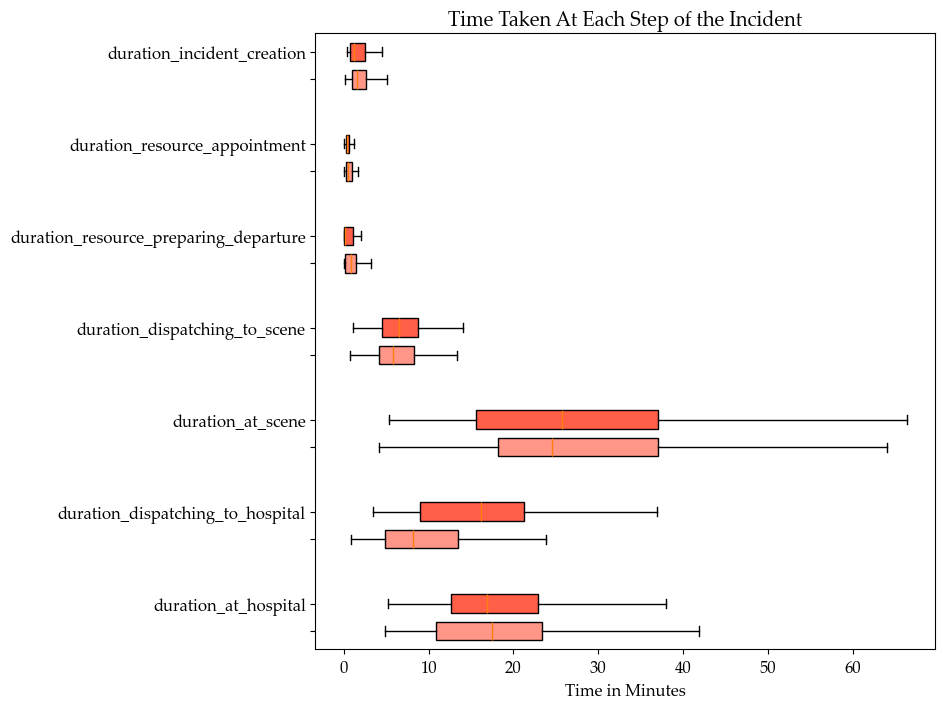

In [12]:
boxplot_time_at_steps(
    historic_dataframe=data_loader.enhanced_incidents_df,
    simulated_dataframe=df,
    bounds=("2018-03-20 07:00:00", "2018-03-20 18:59:59"),
    triage_impressions=["A"]
)


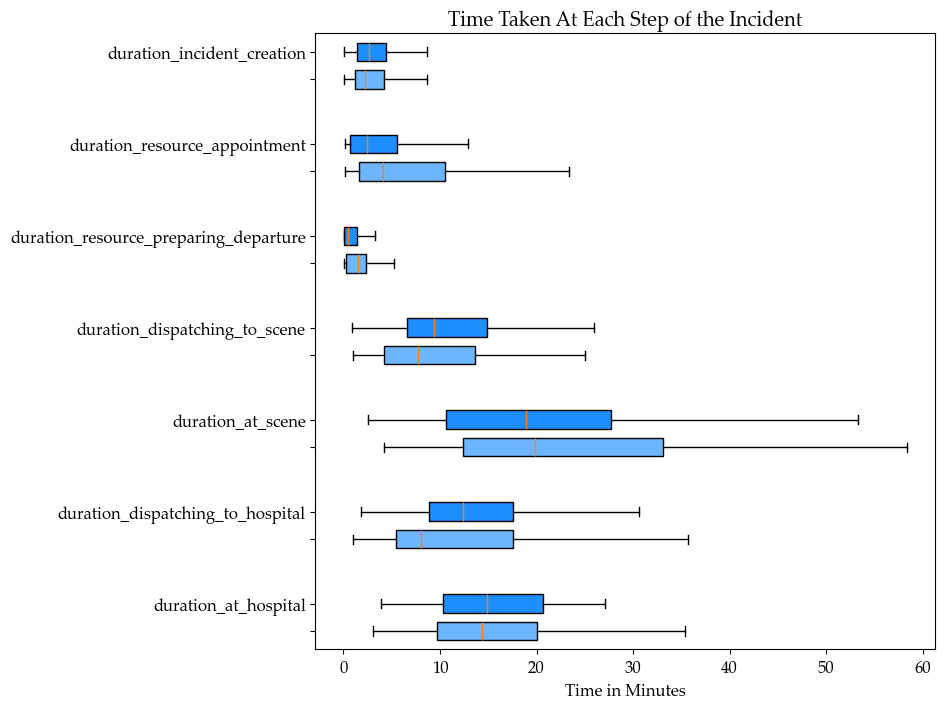

In [13]:
boxplot_time_at_steps(
    historic_dataframe=data_loader.enhanced_incidents_df,
    simulated_dataframe=df,
    bounds=("2018-03-20 07:00:00", "2018-03-20 18:59:59"),
    triage_impressions=["H"]
)

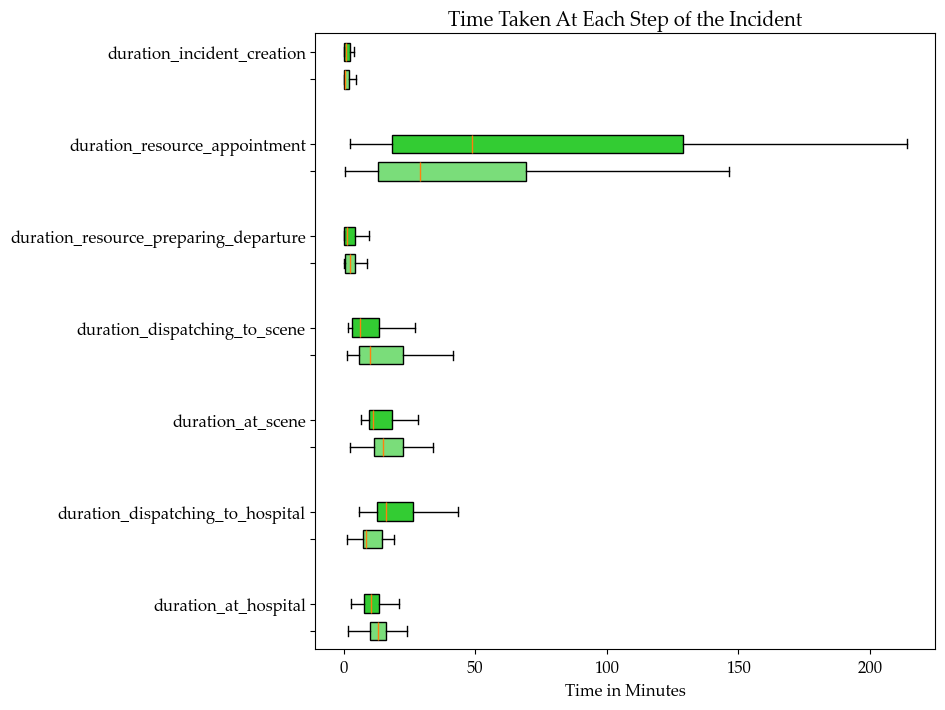

In [14]:
boxplot_time_at_steps(
    historic_dataframe=data_loader.enhanced_incidents_df,
    simulated_dataframe=df,
    bounds=("2018-03-20 07:00:00", "2018-03-20 18:59:59"),
    triage_impressions=["V1"]
)

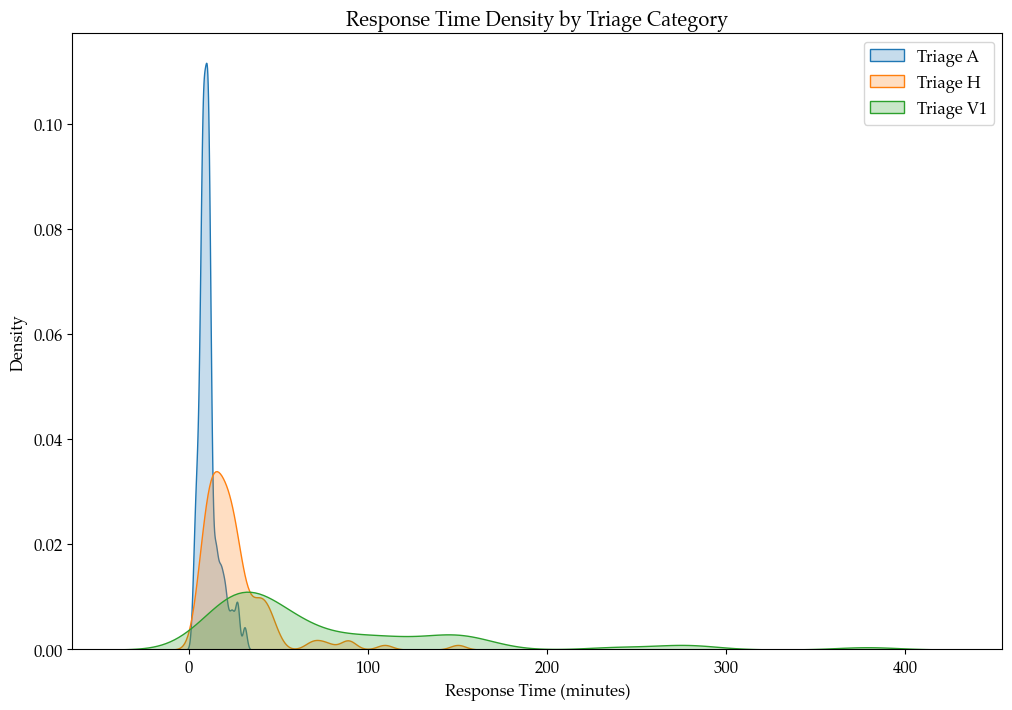

In [15]:
plot_response_time_density(df)


In [16]:
print_mean_median(df)


Triage,Urban,Mean (min),Median (min)
A,Yes,10.540000,9.760000
H,Yes,25.440000,19.550000
V1,Yes,78.900000,49.080000
A,No,16.950000,17.250000
H,No,35.470000,38.050000
V1,No,63.300000,63.300000
